# Planet hunting

## Jay Dhanoa & Andy Ham

https://xkcd.com/1371/

This assignment is a huge throwback to my four years of doing Astronomy on Science Olympiad. Our senior year exams actually involved looking at light curves like these to determine whether or not a star had one or more exoplanets, or whether or not a system was a binary star system, etc.

In [1]:
import re
import operator
import math
import string
import nltk
import cPickle
import time
import scipy
import cPickle
import csv
import numpy as np
from scipy import sparse
from operator import add
from scipy import sparse
from pyspark.sql import SparkSession, Row
from collections import Counter
from pprint import pprint

spark  = SparkSession.builder.config("spark.driver.maxResultSize", "20g")\
.master('local[56]').appName('planets').getOrCreate()

lc = spark.read.json('/project/cmsc25025/light_curve/lightcurves-sample.json')

Inspecting the data:

In [2]:
print(lc)
sample = lc.take(1)[0]
print(len(sample['flux']))
print(len(sample['time']))
print(lc.count())

DataFrame[flux: array<double>, label: string, name: string, time: array<double>]
4757
4757
12


We have 12 light curves.

Each entry has the following fields:
* Label
    * conf: star confirmed to have planets
    * fp: confirmed to have no planets
    * eb: confirmed to be an _eclipsing binary star system_ which has no planet
* Name
* Flux [4757]
* Time [4757]

Inspecting one of the flux data sets:

In [3]:
print(sample['flux'])

[194602.078125, 194659.140625, 194674.859375, 194692.046875, 194718.21875, 194790.171875, 194811.765625, 194813.640625, 194826.859375, 194851.75, 194871.5, 194903.3125, 194941.171875, 194940.625, 194987.03125, 195005.140625, 195012.203125, 195010.71875, 195062.9375, 195062.671875, 195118.734375, 195119.21875, 195147.703125, 195154.734375, 195211.859375, 195198.515625, 195219.234375, 195226.234375, 195251.765625, 195255.359375, 195287.90625, 195331.84375, 195329.4375, 195344.15625, nan, 195397.1875, 195394.21875, 195425.328125, 195409.578125, 195438.5, 195443.46875, 195475.609375, 195448.0625, 195499.5625, 195500.4375, 195533.9375, 195531.78125, 195567.640625, 195537.5, 195577.046875, 195585.171875, 195597.21875, 195598.515625, 195617.484375, 195627.5, 195615.53125, 195628.953125, 195630.46875, 195643.6875, 195644.703125, 195657.9375, 195660.671875, 195688.15625, 195718.4375, 195717.5, 195683.296875, 195703.203125, 195687.296875, 195721.890625, 195722.875, 195722.65625, 195728.171875, 1

We have NaN values from indices 757 to 1052, inclusive. There are also 136 other data points, scattered throughout the data, that are NaNs. Checking whether or not they're all at the same place:

In [4]:
print(np.array(sample['flux']))
vec = np.array(sample['flux'])
print(sum(np.isnan(vec)))

[ 194602.078125  194659.140625  194674.859375 ...,  180201.75      180192.53125
  180194.53125 ]
432


In [5]:
items = lc.collect()
all_bads = []
for item in items:
    f = item['flux']
    badindices = []
    for i, x in enumerate(f):
        if np.isnan(x):
            badindices.append(i)
    all_bads.append(badindices)
    
for bad_indices in all_bads:
    print(bad_indices==all_bads[0])
    
bad_indices = set(all_bads[0])

True
True
True
True
True
True
True
True
True
True
True
True


In [6]:
print(all_bads[0])
print(len(all_bads[0]))

[34, 95, 241, 342, 387, 517, 533, 679, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 9

Fortunately for us, from inspecting these indices in a different cell they're all at the same place, so I can safely toss out those values.

Intuitively, turning all those values to zero would drag down our regression curve a lot near/around the NaN window, so throwing them out seems like the most logical option.

In [7]:
def remove_nans(data):
    result = []
    for i, x in enumerate(data):
        if i not in bad_indices:
            result.append(data[i])
    return result

Now, onto kernel smoothing. We will be using the Epanachnikov kernel, per the example provided in the PSET.

[ 194635.23941542  194651.32176825  194672.27887785 ...,  180199.73663233
  180197.60762538  180194.87494925]


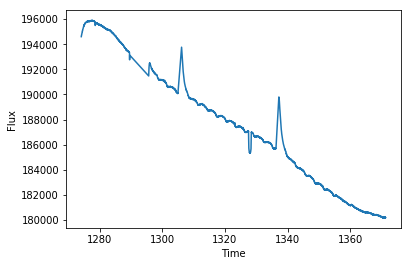

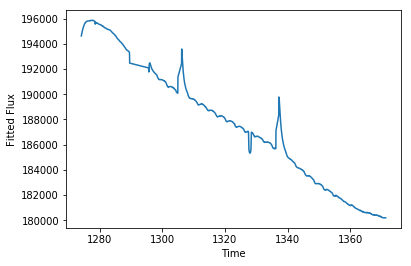

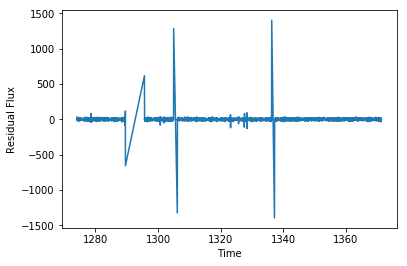

In [8]:
gap = 0.0204
N = len(remove_nans(sample['flux']))
sz = (N-1)/2
u = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)

def kernel_epa(u):
    w = (abs(u) <=1) * (1-u*u)
    return w[w>0]


def ckernel_epa(u):
    w = (3/4) * (abs(u) <=1) * (1-u*u)
    return w[w>0]

h = 0.05
w = kernel_epa(u/h)

time = remove_nans(sample['time'])
flux = remove_nans(sample['flux'])

const = np.convolve(w, np.ones(len(flux), dtype=np.float64), 'same')
yhat = np.convolve(w, np.nan_to_num(flux), 'same') / const
print(yhat)
import matplotlib.pyplot as plt
plt.plot(time, flux)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()
plt.plot(time, yhat)
plt.xlabel('Time')
plt.ylabel('Fitted Flux')
plt.show()
r = yhat-flux
plt.xlabel('Time')
plt.ylabel('Residual Flux')
plt.plot(time, r)
plt.show()

Plotting the initial residuals:

Standardizing the residuals with zero mean and variance 1:

MAD: 7.93848880386


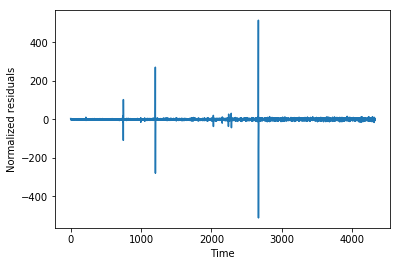

Normalized mean: -0.0001336666821


In [9]:
def MAD(X):
    return np.nanmedian(np.absolute(X-np.nanmedian(X)))

def normalize(r):
    mean = np.nanmean(r)
    for i, elem in enumerate(r):
        r[i] = (r[i]-mean)/MAD(r)
    return r
    
print("MAD: {}".format(MAD(r)))
rnormal = normalize(r)
n = len(rnormal)
plt.xlabel('Time')
plt.ylabel('Normalized residuals')
plt.plot(rnormal)
plt.show()

print("Normalized mean: {}".format(np.mean(rnormal)))

Now that we have this, we need to put the light curve through part **d**: computing the universal threshold.

CUTOFF: 4.0919842178


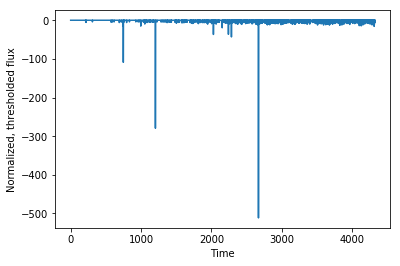

In [10]:
beta = np.sqrt(2 * np.log(n))
print("CUTOFF: {}".format(beta))
rthresh = [0]*n
for i, x in enumerate(r):
    if rnormal[i] < -beta:
        rthresh[i] = rnormal[i]
    else:
        rthresh[i] = 0

plt.xlabel('Time')
plt.ylabel('Normalized, thresholded flux')
plt.plot(rthresh)
plt.show()

Ok, so now that we have the pipeline going, we just need to implement our leave one out cross validation, to find the optimal bandwidth $h$.

In [11]:
def sckernel_epa(u, h):
    """Incorporates the 3/4, for a single value"""
    if np.absolute(u)<=h:
        return (3.0/4) * (1-u*u)
    else:
        return 0

def lii(x, y, h):
    results = []
    for i in range(len(x)):
        denom = 0
        for j in range(len(y)):
            denom += sckernel_epa(x[i]-x[j], h)
        results.append(sckernel_epa(0, h)/denom)
    return np.array(results)

def risk(x, y, h):
    gap = 0.0204
    u = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)
    vec = lii(x, y, h)
    w = kernel_epa(u/h)
    const = np.convolve(w, np.ones(len(y), dtype=np.float64), 'same')
    yhat = np.convolve(w, np.nan_to_num(y), 'same') / const
    r = 0
    for i in range(len(y)):
        r += ((y[i]-yhat[i])/(1-vec[i]))**2
    return (1.0/len(y))*r

vals = np.arange(0.05, 5, 0.05)
df = spark.sparkContext.parallelize(vals).map(lambda x: risk(time, flux, x))

risk_vals = df.collect()
pprint(risk_vals)

[4754.1130558525329,
 6778.7687494537868,
 9001.5918014708986,
 11653.151710763737,
 14263.422548687317,
 17122.301270896918,
 19926.05069910987,
 22884.95534138706,
 25756.654647214615,
 28767.10486353017,
 31760.21267851079,
 34761.151023588383,
 37811.458389718951,
 40855.884897618489,
 43937.90428715841,
 46988.633961172483,
 50049.863884704733,
 53046.3449297158,
 56018.937726801407,
 58916.625357914716,
 61778.911010685733,
 64568.590112614736,
 67354.007437252527,
 70066.227106179969,
 72864.520142394598,
 75600.502955719814,
 78676.595263728435,
 81789.417080941639,
 85418.578855939006,
 94212.398988933477,
 141908.34543618691,
 98557.804287357634,
 100744.6050882991,
 171534.99526712397,
 4863701.5063238014,
 3657475.8171432689,
 190072.33636434114,
 100420.99466378856,
 108038.08469551307,
 96835.825573084658,
 96429.187786840092,
 98290.679555336363,
 100140.23237234566,
 101745.66006799483,
 103366.2008373467,
 104841.37391286829,
 106322.74531848653,
 107702.43010387651,
 

I'm not entirely sure how to implement leave one out cross validation with the convolutional method, so instead I'll be reimplementing the whole thing by hand. It's a task that's well suited to parallelization, so it shouldn't be that bad.

### Reimplementing Nadaraya-Watson

From here on out I'm instead going to be implementing the kernel estimator from scratch.

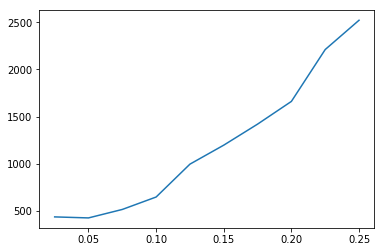

Bandwith with smallest risk: 0.05


In [12]:
def sckernel_epa(u, h):
    """Incorporates the 3/4, for a single value"""
    if np.absolute(u)<=h:
        return (3.0/4) * (1-u*u)
    else:
        return 0
    
def m(X, Y, x, h):
    numerator = 0
    denominator = 0
    startflag = False
    for i in range(len(X)):
        kernresult = sckernel_epa(X[i]-x, h)
        if not startflag and kernresult != 0:
            startflag = True
        if startflag and not kernresult:
            break
        numerator += Y[i] * kernresult
        denominator += kernresult
    if not denominator:
        return 0
    return numerator/denominator


def mvec(X, Y, h):
    return np.array(map(lambda x: m(X, Y, x, h), X))

def leaveiout(data, i):
    return data[:i] + data[(i+1):]

def risk(X, Y, h):
    total = 0
    n = len(Y)
    for i in range(n):
        tempx = leaveiout(X, i)
        tempy = leaveiout(Y, i)
        total += (Y[i]-m(tempx, tempy, X[i], h))**2
    return (1.0/n) * total
        
vals = np.arange(0.025, 0.25+0.025, 0.025)
df = spark.sparkContext.parallelize(vals)

# risk_vals = map(lambda x: risk(time, flux, x), vals)

risk_vals = df.map(lambda x: risk(time, flux, x)).collect()

plt.plot(vals, risk_vals)
plt.show()

min_risk = min(risk_vals)
min_h = vals[risk_vals.index(min_risk)]

print("Bandwith with smallest risk: {}".format(min_h))

Re-plotting our above data with this bandwidth:

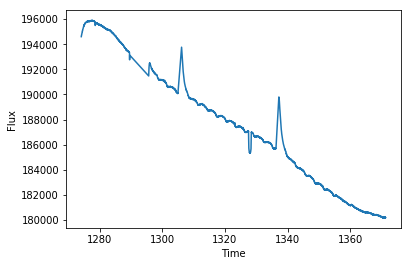

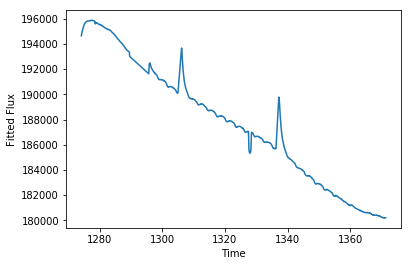

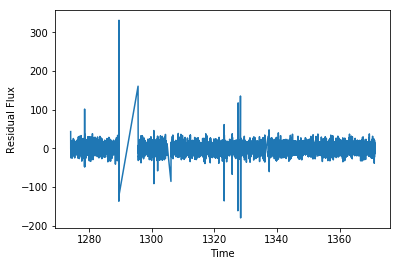

In [13]:
yhat = mvec(time, flux, 0.05)
plt.plot(time, flux)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()
plt.plot(time, yhat)
plt.xlabel('Time')
plt.ylabel('Fitted Flux')
plt.show()
r = yhat-flux
plt.xlabel('Time')
plt.ylabel('Residual Flux')
plt.plot(time, r)
plt.show()

MAD: 8.94753838758


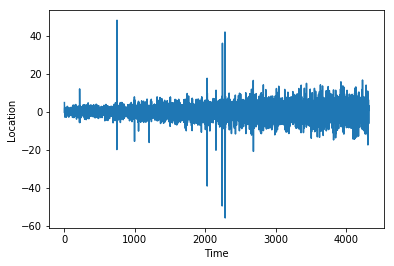

Normalized mean: -0.00206544937386
CUTOFF: 4.0919842178


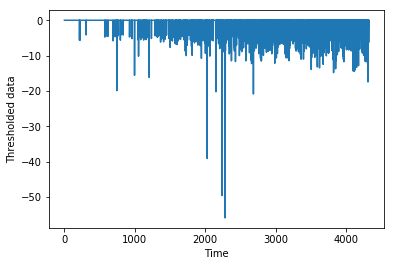

In [14]:
print("MAD: {}".format(MAD(r)))
rnormal = normalize(r)
n = len(rnormal)
plt.xlabel('Time')
plt.ylabel('Location')
plt.plot(rnormal)
plt.show()

print("Normalized mean: {}".format(np.mean(rnormal)))

beta = np.sqrt(2 * np.log(n))
print("CUTOFF: {}".format(beta))
rthresh = [0]*n
for i, x in enumerate(r):
    if rnormal[i] < -beta:
        rthresh[i] = rnormal[i]
    else:
        rthresh[i] = 0
plt.xlabel('Time')
plt.ylabel('Thresholded data')
plt.plot(rthresh)
plt.show()

## RESULTS

With our curve fitting method in hand, we can then proceed to do this for the rest of the data:

In [15]:
curves = lc.collect()

def analyze(ind, lc):
    time, flux = remove_nans(lc['time']), remove_nans(lc['flux'])
    risk_vals = df.map(lambda x: risk(time, flux, x)).collect()
    min_risk = min(risk_vals)
    min_h = vals[risk_vals.index(min_risk)]
    plt.plot(time, flux)
    plt.title('LIGHT CURVE {}'.format(ind))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.show()
    yhat = mvec(time, flux, h)
    plt.plot(time, yhat)
    plt.title('FITTED LIGHT CURVE {}'.format(ind))
    plt.xlabel('Time')
    plt.ylabel('Fitted Flux')
    plt.show()
    r = flux-yhat
    rnormal = normalize(r)
    beta = np.sqrt(2 * np.log(n))
    print("Bandwidth with smallest risk: {}".format(min_h))
    print("CUTOFF: {}".format(beta))
    rthresh = [0]*n
    for i, x in enumerate(r):
        if rnormal[i] < -beta:
            rthresh[i] = rnormal[i]
        else:
            rthresh[i] = 0   
    
    plt.xlabel('Time')
    plt.ylabel('Thresholded data')
    plt.plot(time, rthresh)
    plt.show()

### Generated, fitted light curves

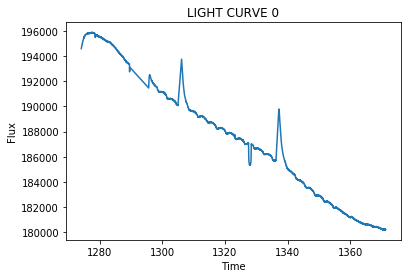

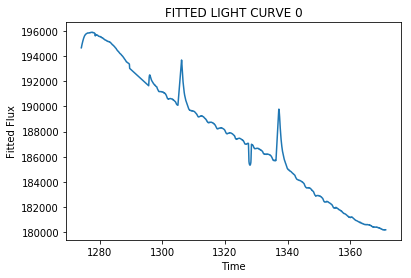

Bandwidth with smallest risk: 0.05
CUTOFF: 4.0919842178


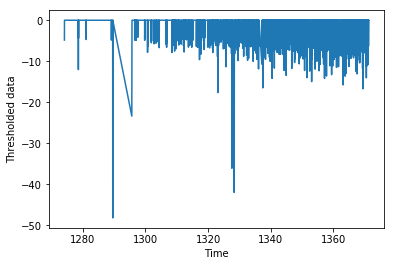

In [16]:
analyze(0, curves[0])

Light curve 0 seems pretty noisy, and doesn't have the same distinguishable features that we see below. I'd classify this as having no planets.

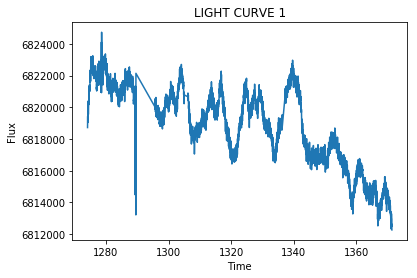

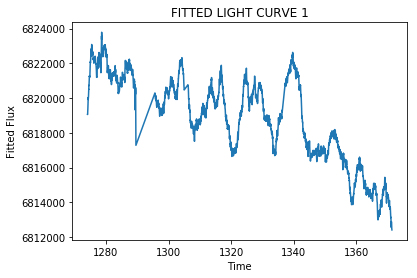

Bandwidth with smallest risk: 0.125
CUTOFF: 4.0919842178


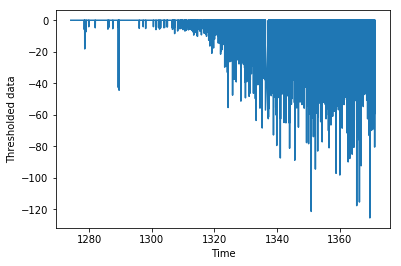

In [17]:
analyze(1, curves[1])

Same here. The lack of regular patterns & the generally noisy signal suggests no planet. 

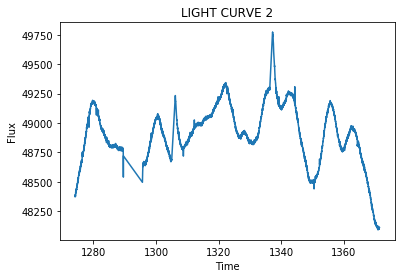

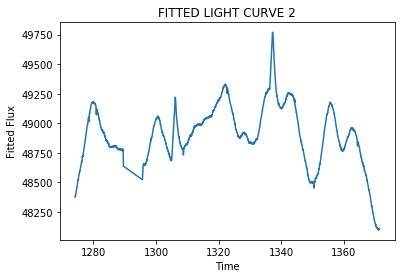

Bandwidth with smallest risk: 0.075
CUTOFF: 4.0919842178


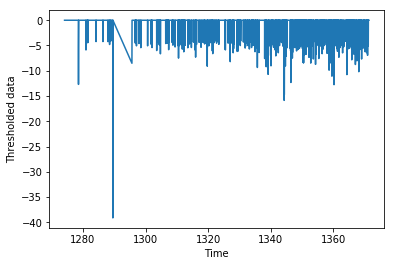

In [18]:
analyze(2, curves[2])

Once *again*, while we do have some standout features, they aren't at regular intervals or magnitudes. At all. It doesn't help that even after fitting the data is relatively noisy. The issue of signal being hard to distinguish from noise is also something that came up in spectroscopy, and at least from our initial analysis, this doesn't look like anything.

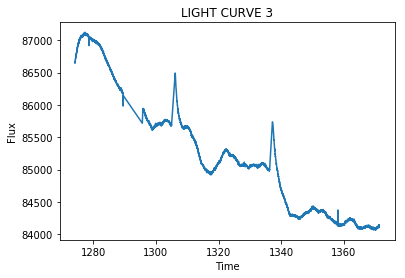

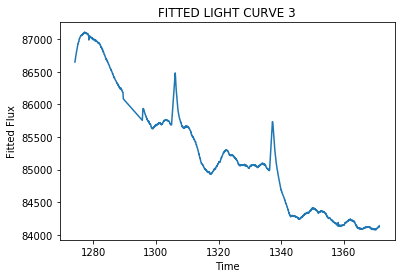

Bandwidth with smallest risk: 0.1
CUTOFF: 4.0919842178


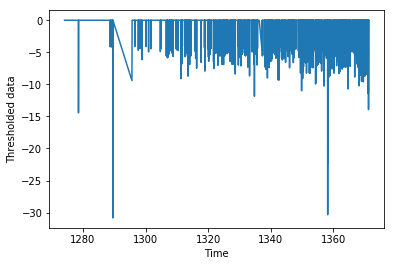

In [19]:
analyze(3, curves[3])

Light curve 3 has the same pretty high signal-to-noise ratio, which makes it hard to say that there is an exoplanet around.

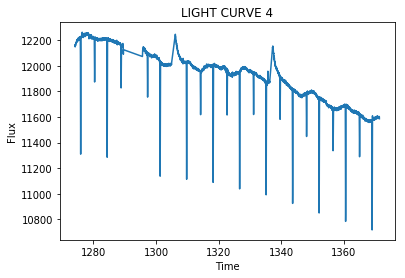

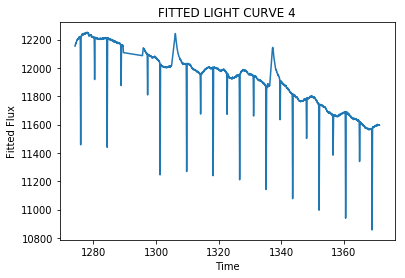

Bandwidth with smallest risk: 0.025
CUTOFF: 4.0919842178


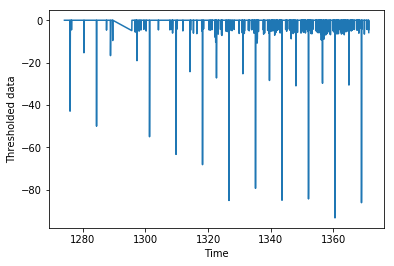

In [20]:
analyze(4, curves[4])

AW YEAH.

So this is much more familiar, and is definitely characteristic of a binary star system. When you have very uneven dips in the light like this, it's indicative that one of the stars is substantially larger than the other, usually a white dwarf, neutron star, or black hole. The smaller star emits a disproportionately large amount of radiation, often in the form of X-rays.

Kepler observes a 'normal' amount of brightness from the stars when they are next to each other (e.g. not eclipsing one another). When the smaller star is eclipsing the larger star, this results in the shorter of the two drops. On the other hand, when the larger star eclipses the smaller star, then the larger dip occurs. This difference in brightnes can be accounted for by the fact that the smaller star is often much more intense from an emissions perspective (usually due to the smaller star pulling matter from the gas giant).

Another important thing to remember when observing eclipsing binary star light curves is the fact that magnitude is a good way to distinguish their light curves from that of exoplanets. This is on account of the fact that exoplanets are usually much smaller and much less dim than the stars they orbit, so you don't see nearly the same degree of brightness disparity from a planet eclipsing the sun or vice versa.

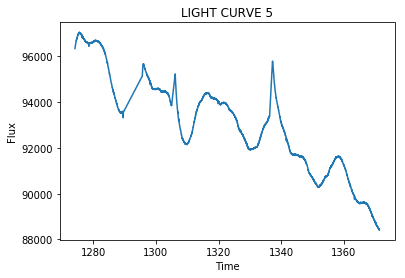

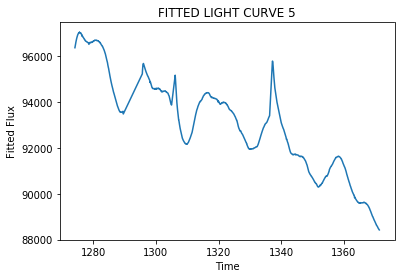

Bandwidth with smallest risk: 0.05
CUTOFF: 4.0919842178


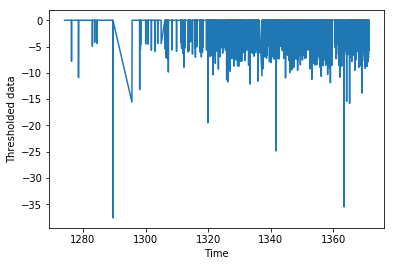

In [21]:
analyze(5, curves[5])

We once again have several well-defined features here, each of which are on an order of magnitude consistent with the last eclipsing binary. Would categorize as eclipsing binary.

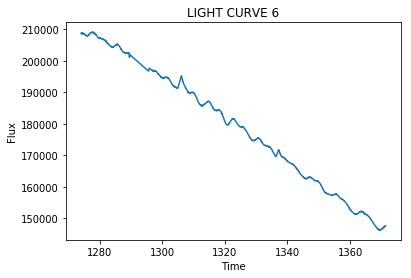

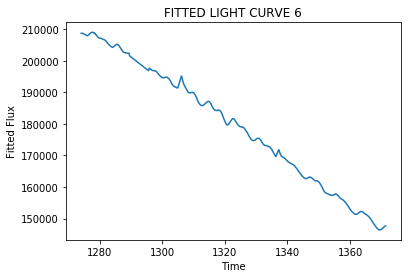

Bandwidth with smallest risk: 0.025
CUTOFF: 4.0919842178


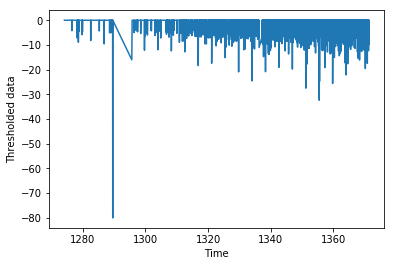

In [22]:
analyze(6, curves[6])

This one's a bit harder to determine, given the increased regularity of the decreases in brightness. Given that the decreases in brightness are closer in magnitude to the eclipsing binary curves of before than the shorter, more frequent dips which we see after, I'm inclined to indicate this is a binary.

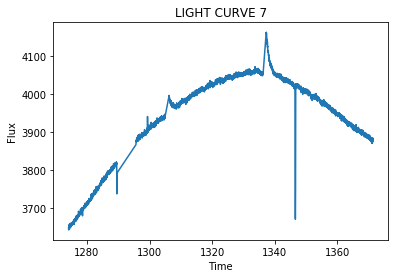

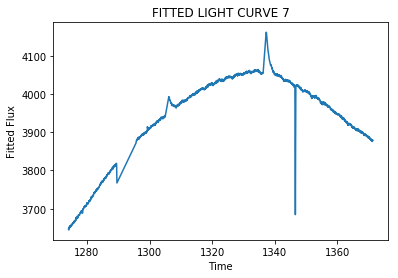

Bandwidth with smallest risk: 0.025
CUTOFF: 4.0919842178


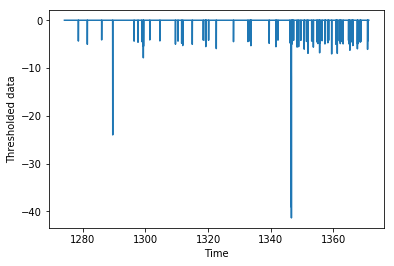

In [23]:
analyze(7, curves[7])

The two peaks actually do look like signal, and the relatively long period in tandem with dips in brightness that are closer to each other than normal would make this consistent with two fairly large stars in a binary system, with possibly small planetoids orbiting the binary stars as well.

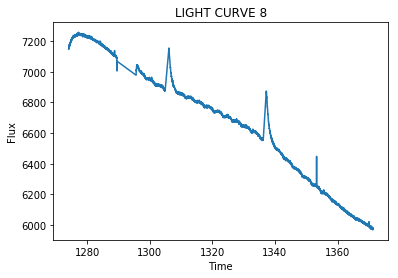

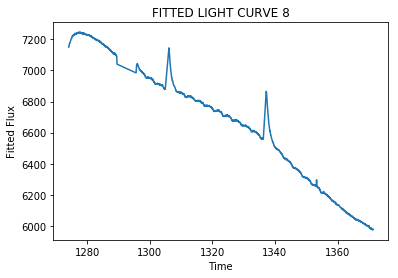

Bandwidth with smallest risk: 0.125
CUTOFF: 4.0919842178


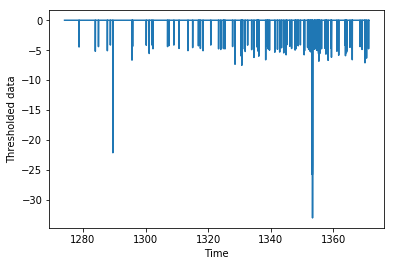

In [24]:
analyze(8, curves[8])

The smaller decreases in magnitude are more consistent with an exoplanet. Larger stars would be brighter, and smaller stars would very often be emitting x rays by virtue of pulling gas from the larger star. The only light we see from planets, on the other hand, is that which is reflected off of them from their star.

(fun fact: this light reflecting off of planets is responsible for the phenomena known as earthshine, where the dark side of the moon can become visible due to light reflected off the earth's surface)

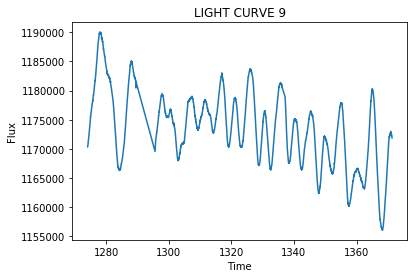

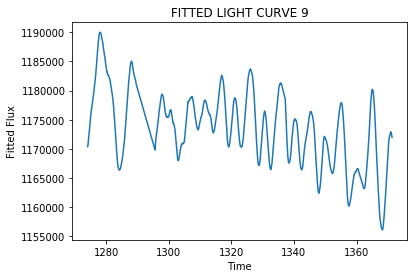

Bandwidth with smallest risk: 0.05
CUTOFF: 4.0919842178


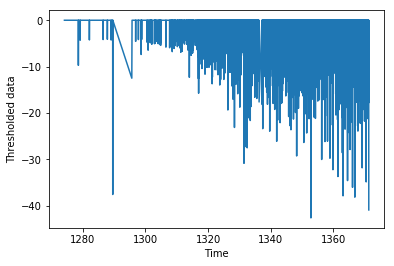

In [25]:
analyze(9, curves[9])

This is too noisy for me to actually be able to make a prediction with any sort of confidence.

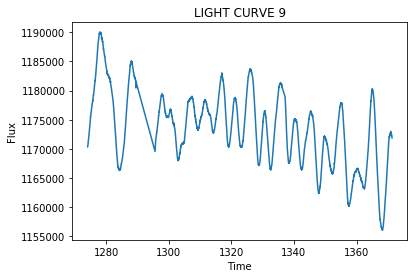

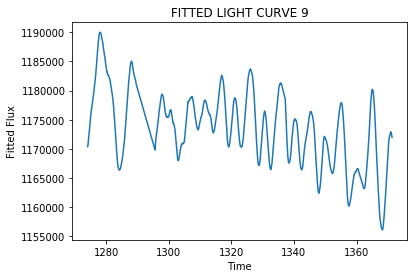

Bandwidth with smallest risk: 0.05
CUTOFF: 4.0919842178


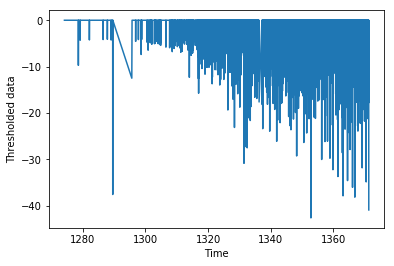

In [26]:
analyze(9, curves[9])

Once again, too noisy.

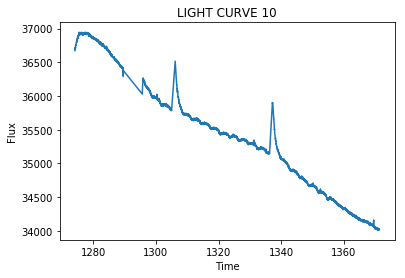

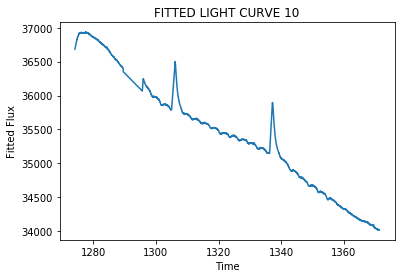

Bandwidth with smallest risk: 0.1
CUTOFF: 4.0919842178


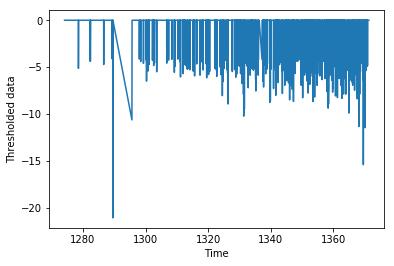

In [27]:
analyze(10, curves[10])

The magnitude here is consistent with that of an exoplanet, but once again noise to signal ratio is pretty high. Nevertheless, we do have some notable features at ~1290, ~1330, and ~1370. While the feature at ~1290 is accounted for at least in part by the gap in our data, the third peak would fall around the region of NaNs.

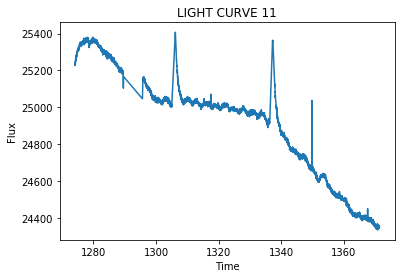

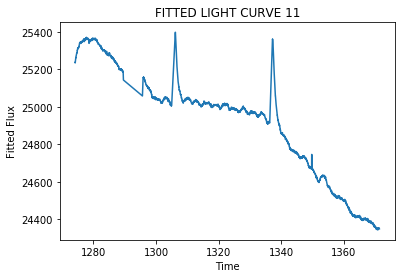

Bandwidth with smallest risk: 0.125
CUTOFF: 4.0919842178


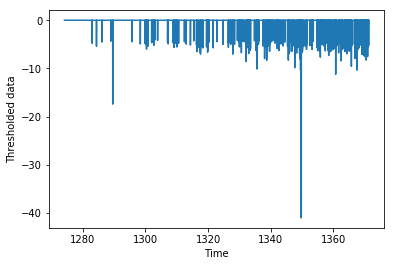

In [28]:
analyze(11, curves[11])

Magnitude is similar to that of exoplanets, but I don't really see regular patterns. In this example, as in prior examples, I actually compared the large peaks in our thresholded data with the original light curve, to determine whether or not they had any validity. 

In [29]:
for curve in curves:
    print(curve['label'])

conf
conf
conf
conf
eb
eb
eb
eb
fp
fp
fp
fp


I wound up being mostly right, short of the few with actual exoplanets where I was relatively confused. I suspect the light curves we got wrong were either around stars of variable brightness, or otherwise had relatively small planets.